In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score,mean_squared_error
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor,RandomForestRegressor
from scipy.stats import boxcox_normmax,skew
from scipy.special import boxcox1p
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
train_y=train['SalePrice']
train_y=np.log1p(train_y)
train=train.drop('SalePrice',axis=1)
df=pd.concat([train,test],axis=0)

In [6]:
df.shape

(2919, 80)

In [7]:
for col in ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
            'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
    df[col]=df[col].fillna(value='No')

In [8]:
tmp=df.astype(object)
deg_=[]
for col in list(tmp.columns):
    tol=tmp[col].value_counts()
    if (tol.iloc[0]//tol.iloc[1]>30) & (sum(tol.iloc[1:])/tmp.shape[0]<=0.1):
        print('degenerate column:',col,': with ratio',sum(tol.iloc[1:])/tmp.shape[0],'and',
             tol.iloc[0]//tol.iloc[1])
        deg_.append(col)

degenerate column: Street : with ratio 0.0041109969167523125 and 242
degenerate column: Utilities : with ratio 0.00034258307639602604 and 2916
degenerate column: Condition2 : with ratio 0.010277492291880781 and 222
degenerate column: RoofMatl : with ratio 0.01473107228502912 and 125
degenerate column: Heating : with ratio 0.015416238437821172 and 106
degenerate column: LowQualFinSF : with ratio 0.013703323055841042 and 719
degenerate column: Functional : with ratio 0.0685166152792052 and 38
degenerate column: 3SsnPorch : with ratio 0.012675573826652964 and 960
degenerate column: ScreenPorch : with ratio 0.08770126755738267 and 204
degenerate column: PoolArea : with ratio 0.004453579993148339 and 2906
degenerate column: PoolQC : with ratio 0.0034258307639602604 and 727
degenerate column: MiscVal : with ratio 0.03528605686879068 and 156


In [9]:
df=df.drop(deg_,axis=1)

In [10]:
pd.DataFrame(df.isnull().sum()/df.shape[0]).sort_values(0,ascending=False)[:20]

,0
LotFrontage,0.166495
GarageYrBlt,0.054471
MasVnrType,0.008222
MasVnrArea,0.007879
MSZoning,0.001370
BsmtFullBath,0.000685
BsmtHalfBath,0.000685
TotalBsmtSF,0.000343
GarageCars,0.000343
Electrical,0.000343


In [11]:
num_=[]
for col in list(df.columns)[1:]:
    if np.dtype(train[col])!=object:
        num_.append(col)

df_num=df[num_]
df_obj=df.drop(num_,axis=1)

In [12]:
tmp=df_num.copy()
tmp['y']=train_y
tmp=tmp.corr()

In [13]:
high=list(pd.DataFrame(tmp['y']).sort_values('y',ascending=False).index[1:11])

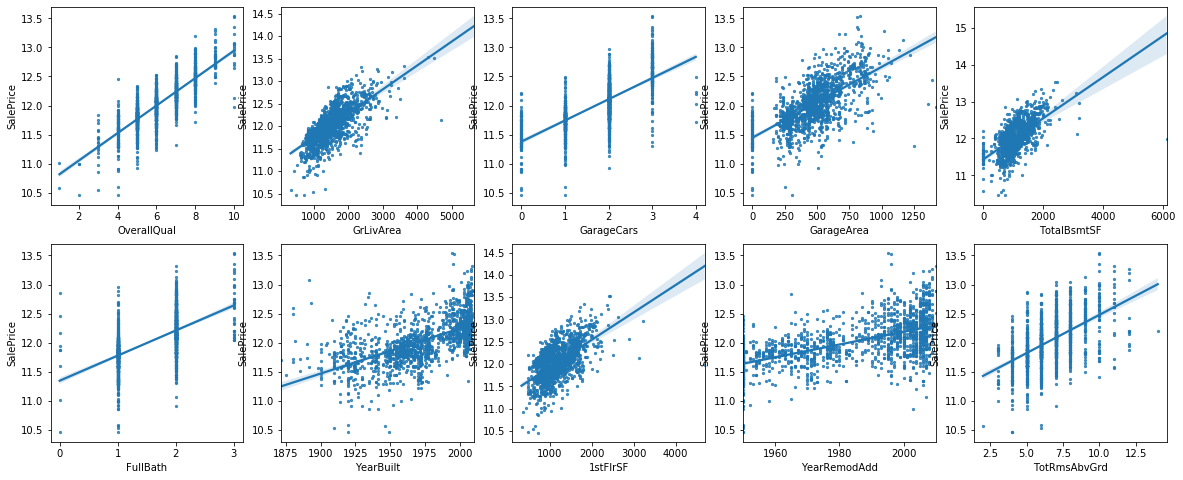

In [14]:
plt.figure(figsize=(20,8))
i=1
for col in high:
    plt.subplot(2,5,i)
    i+=1
    sns.regplot(x=df[col][:1460],y=train_y,scatter_kws={'s':5})

In [15]:
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8654248f50>,
      dtype=object)

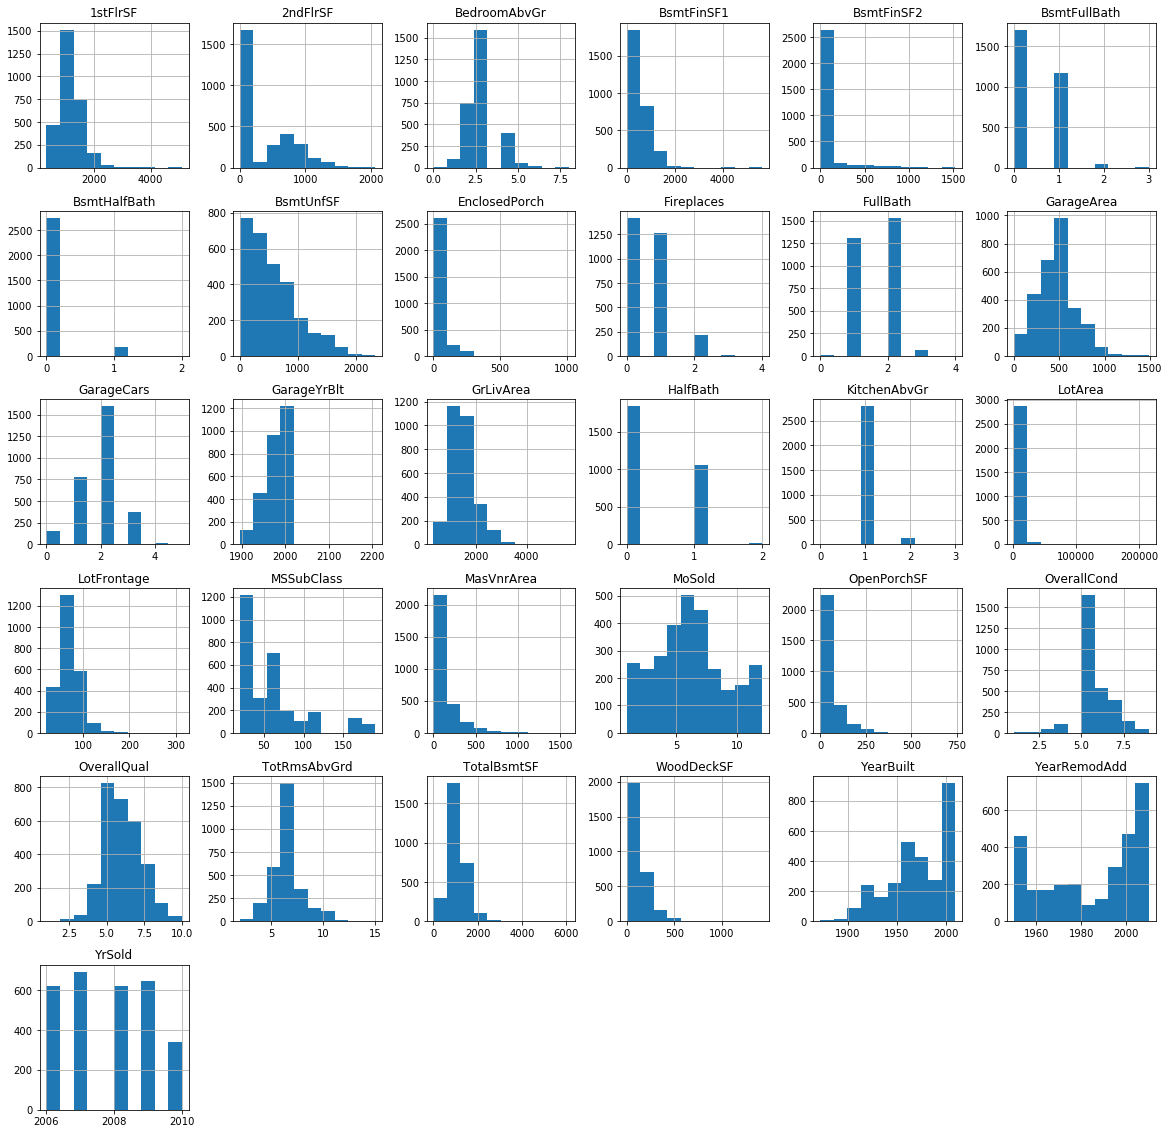

In [16]:
df_num.hist(figsize=(20,20))

In [17]:
df_num.loc[df_num.GarageYrBlt>2020,'GarageYrBlt']=np.nan

# for col in list(df_num.columns):
#     if abs(skew(df_num[col]))>0.5:
#         df_num.loc[df_num[col]>df_num[col].quantile(0.75),col]=np.nan
#         df_num.loc[df_num[col]<df_num[col].quantile(0.25),col]=np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86599c33d0>,
      dtype=object)

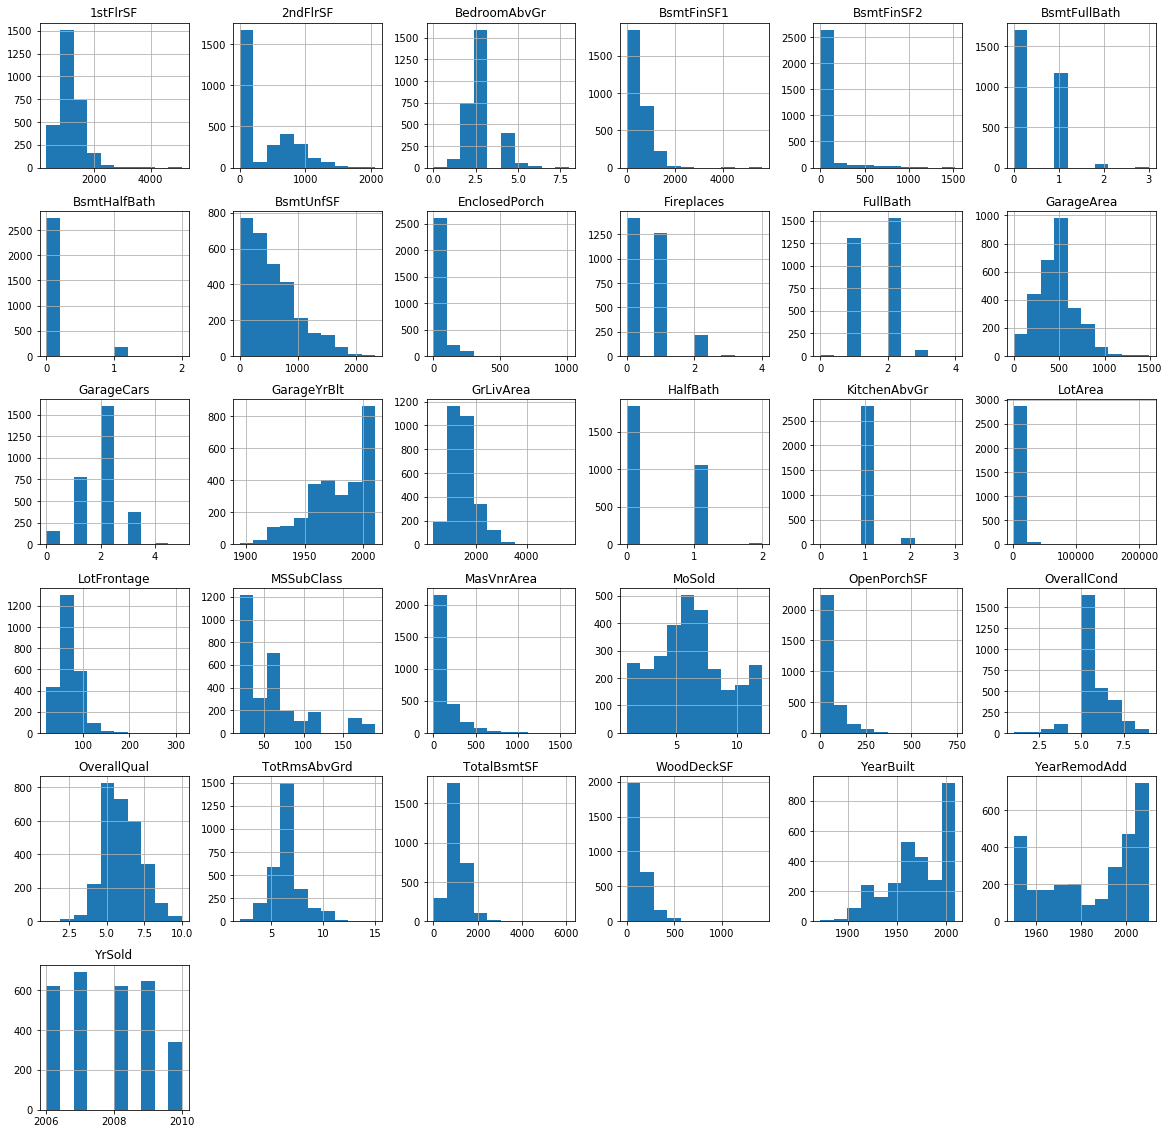

In [18]:
df_num.hist(figsize=(20,20))

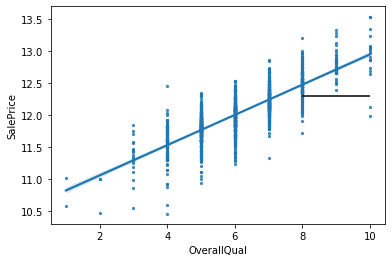

In [19]:
sns.regplot(x=df_num['OverallQual'][:1460],y=train_y,scatter_kws={'s':5})
plt.hlines(y=12.3,xmin=8,xmax=10)

In [20]:
df_num['y']=train_y

In [21]:
df_num.loc[(df_num.OverallQual==4)&(df_num.y>12.4),'OverallQual']=np.nan
df_num.loc[(df_num.OverallQual==4)&(df_num.y<10.7),'OverallQual']=np.nan
df_num.loc[(df_num.OverallQual==3)&(df_num.y<10.7),'OverallQual']=np.nan
df_num.loc[(df_num.OverallQual==2)&(df_num.y<10.7),'OverallQual']=np.nan
df_num.loc[(df_num.OverallQual==10)&(df_num.y<12.3),'OverallQual']=np.nan

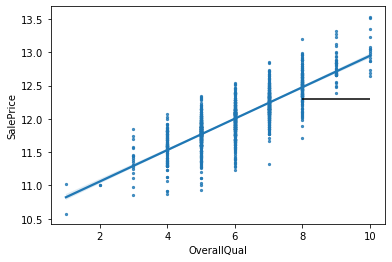

In [22]:
sns.regplot(x=df_num['OverallQual'][:1460],y=train_y,scatter_kws={'s':5})
plt.hlines(y=12.3,xmin=8,xmax=10)

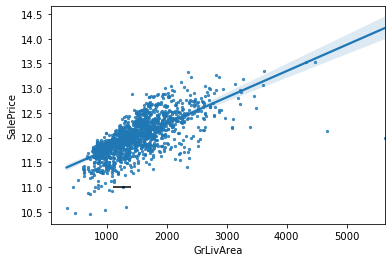

In [23]:
sns.regplot(x=df_num['GrLivArea'][:1460],y=train_y,scatter_kws={'s':5})
# plt.hlines(y=12.75,xmin=1350,xmax=1700)
plt.hlines(y=11,xmin=1100,xmax=1400)

In [24]:
df_num.loc[(df_num.y<11),'GrLivArea']=np.nan
# df_num.loc[(df_num.y>12.75),'GrLivArea']=np.nan

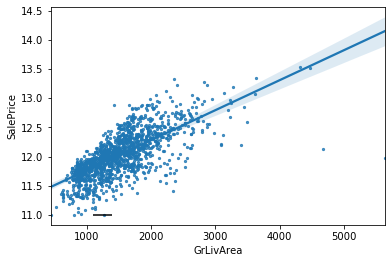

In [25]:
sns.regplot(x=df_num['GrLivArea'][:1460],y=train_y,scatter_kws={'s':5})
# plt.hlines(y=12.75,xmin=1350,xmax=1700)
plt.hlines(y=11,xmin=1100,xmax=1400)

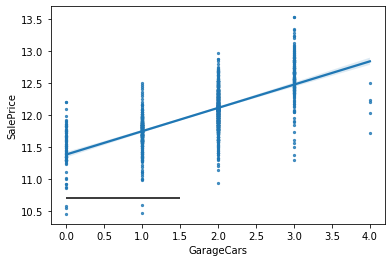

In [26]:
sns.regplot(x=df_num['GarageCars'][:1460],y=train_y,scatter_kws={'s':5})
plt.hlines(y=10.7,xmin=0,xmax=1.5)

In [27]:
df_num.loc[(df_num.y<10.7),'GarageCars']=np.nan

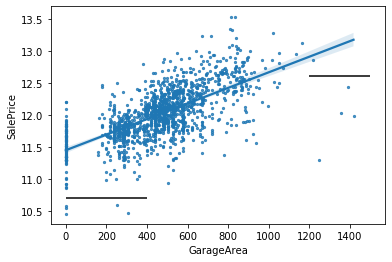

In [28]:
sns.regplot(x=df_num['GarageArea'][:1460],y=train_y,scatter_kws={'s':5})
plt.hlines(y=10.7,xmin=0,xmax=400)
plt.hlines(y=12.6,xmin=1200,xmax=1500)

In [29]:
df_num.loc[(df_num.y<10.7),'GarageArea']=np.nan
df_num.loc[(df_num.y<12.6)&(df_num.GarageArea>1200),'GarageArea']=np.nan

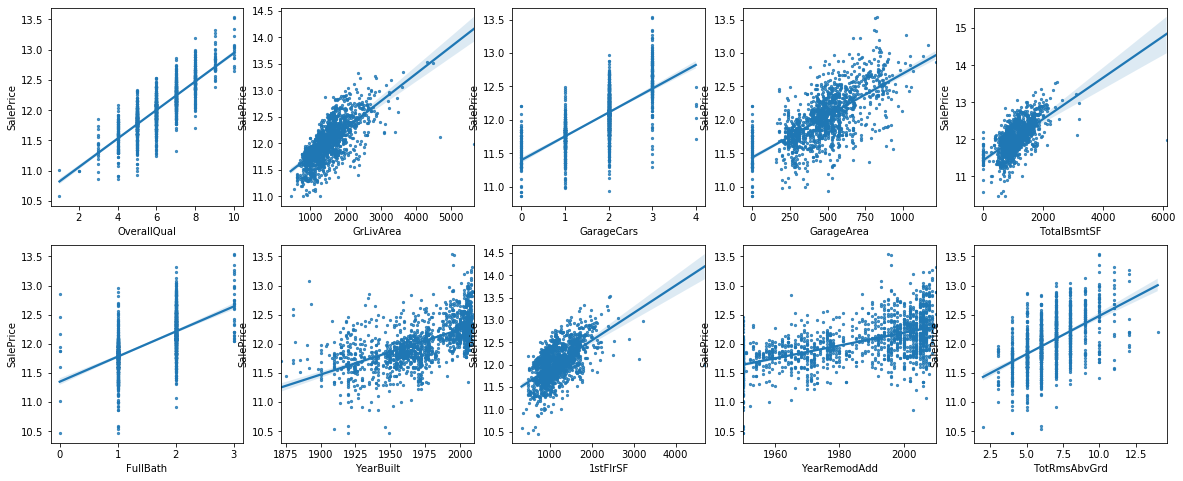

In [30]:
plt.figure(figsize=(20,8))
i=1
for col in high:
    plt.subplot(2,5,i)
    i+=1
    sns.regplot(x=df_num[col][:1460],y=train_y,scatter_kws={'s':5})

In [31]:
# imp=SimpleImputer(strategy='mean')
# df_num=pd.DataFrame(imp.fit_transform(df_num),columns=df_num.columns)

knn=KNNImputer(n_neighbors=8)
df_num=pd.DataFrame(knn.fit_transform(df_num),columns=df_num.columns)

In [32]:
df_num=df_num.drop('y',axis=1)

In [33]:
for col in list(df_num.columns):
    if abs(skew(df_num[col]))>0.5:
        df_num[col]=boxcox1p(df_num[col],boxcox_normmax(df_num[col]+1))

([], <a list of 0 Text xticklabel objects>)

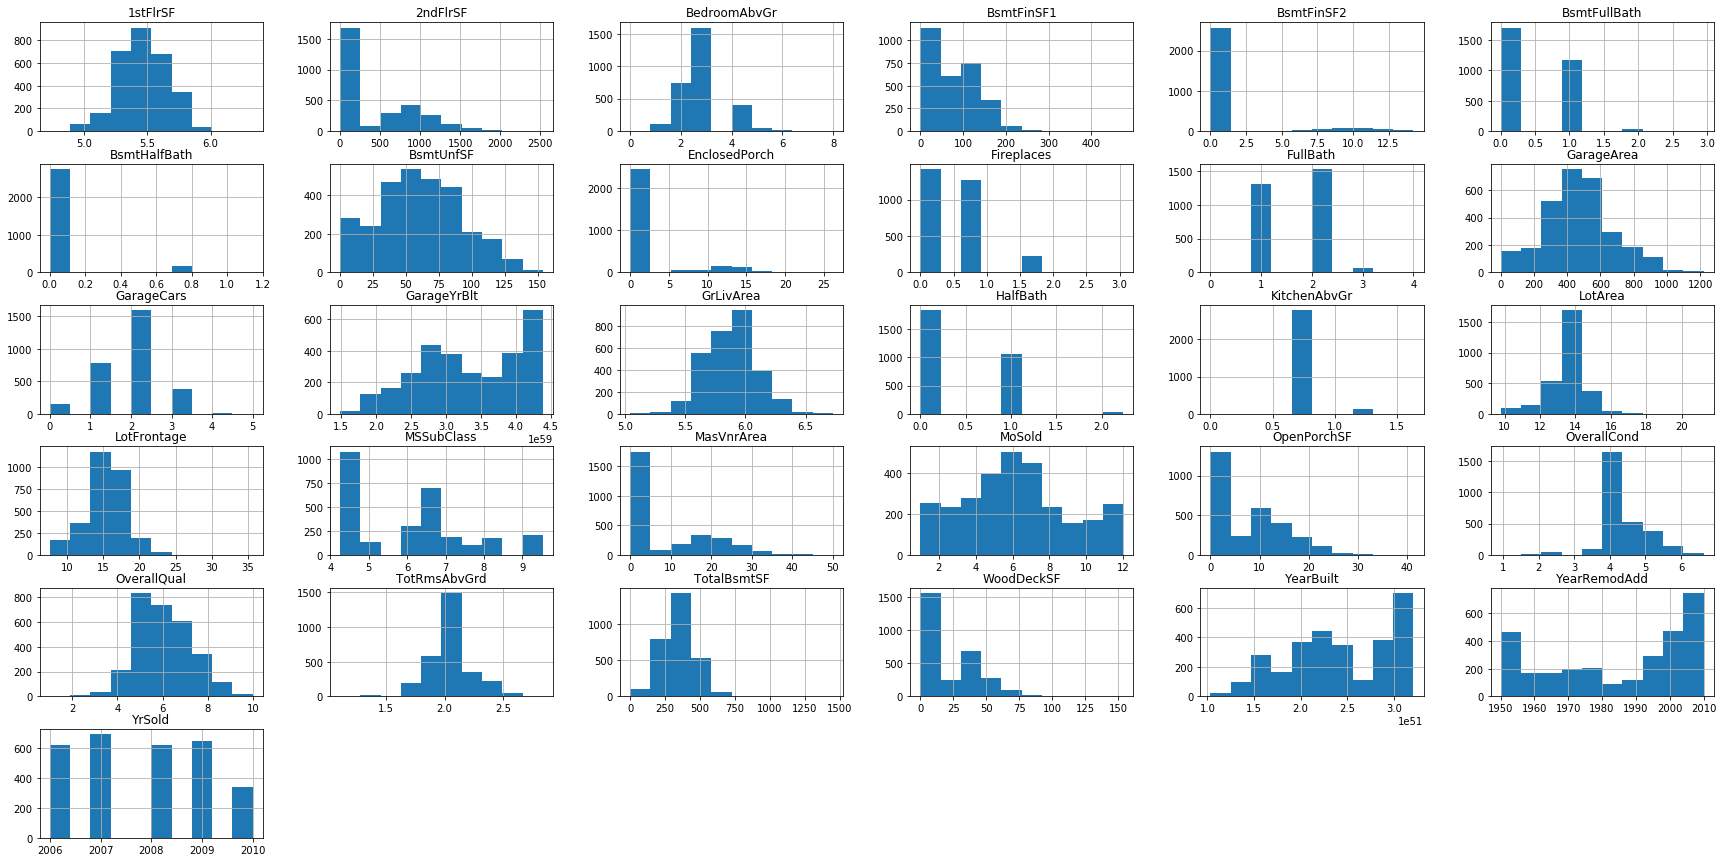

In [34]:
df_num.hist(figsize=(30,15))
plt.yticks(ticks=[])
plt.xticks(ticks=[])

In [35]:
std=StandardScaler()
df_num=pd.DataFrame(std.fit_transform(df_num),columns=df_num.columns)

In [36]:
pca=PCA(n_components=25)
df_num=pd.DataFrame(pca.fit_transform(df_num),columns=['PC'+str(i) for i in range(1,26)])

In [37]:
df_num

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,1.896633,0.894154,-1.795209,1.358566,0.293749,-1.778353,0.283051,0.003003,0.582551,-0.598494,...,-0.215495,-0.312638,0.301011,0.105017,-0.026866,0.118763,0.012504,-0.670718,0.028363,-0.100961
1,-0.029662,-1.555359,1.178973,0.452057,-1.746693,2.417726,-0.486185,2.674023,0.084213,-0.446900,...,-0.195436,0.676102,-0.326422,-0.701174,-0.365125,-1.164337,-0.345142,-0.078570,0.085101,0.525388
2,2.175832,0.691865,-1.302699,0.911115,-0.082286,-0.356651,0.808168,-0.915762,0.070061,-0.160477,...,-0.802974,0.012036,0.539820,0.496964,0.537789,-0.553782,0.458766,-0.433433,-0.324942,-0.045618
3,-0.059634,0.956054,0.793441,0.534155,-0.002936,-0.398615,-1.085772,-2.224891,0.692936,2.788246,...,0.035212,0.536684,-0.572530,-0.158504,1.527102,0.757924,-0.482718,-0.529609,-0.276695,-0.524384
4,4.809102,1.182461,-0.075221,1.388205,-0.219995,0.392379,1.167742,-0.800229,-0.500190,0.313609,...,0.464956,-0.357720,-0.286306,0.266778,0.776802,0.085692,-0.080557,-0.301234,-0.210948,-0.249258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-4.982064,2.774754,-3.176039,0.352755,-0.070800,1.211949,-0.355618,-0.584337,-0.063251,-1.437479,...,-0.185962,0.924344,0.353410,-0.246118,0.057310,-0.403060,0.295799,0.708913,-0.190104,0.404372
2915,-3.753494,2.455546,-3.311656,0.829601,0.580433,0.496092,0.317261,-0.795477,1.149454,-0.638189,...,0.492807,0.931417,-0.713765,-0.864935,0.018156,0.184032,0.318301,0.692940,0.409661,-0.109512
2916,0.612600,-2.285808,3.184949,1.933398,-0.972580,0.152431,1.951907,-0.029160,-2.443472,-0.393412,...,-0.048580,-0.037471,-0.126482,-0.085287,0.787749,0.356252,-0.605965,1.320679,1.059547,0.247685
2917,-2.684191,-0.145269,-0.306095,-0.561931,-0.532371,2.681426,0.944534,1.750282,1.085550,-2.523706,...,0.135718,0.447064,1.234784,0.715867,0.625382,0.824094,-0.164413,0.369408,-0.329017,-0.295812


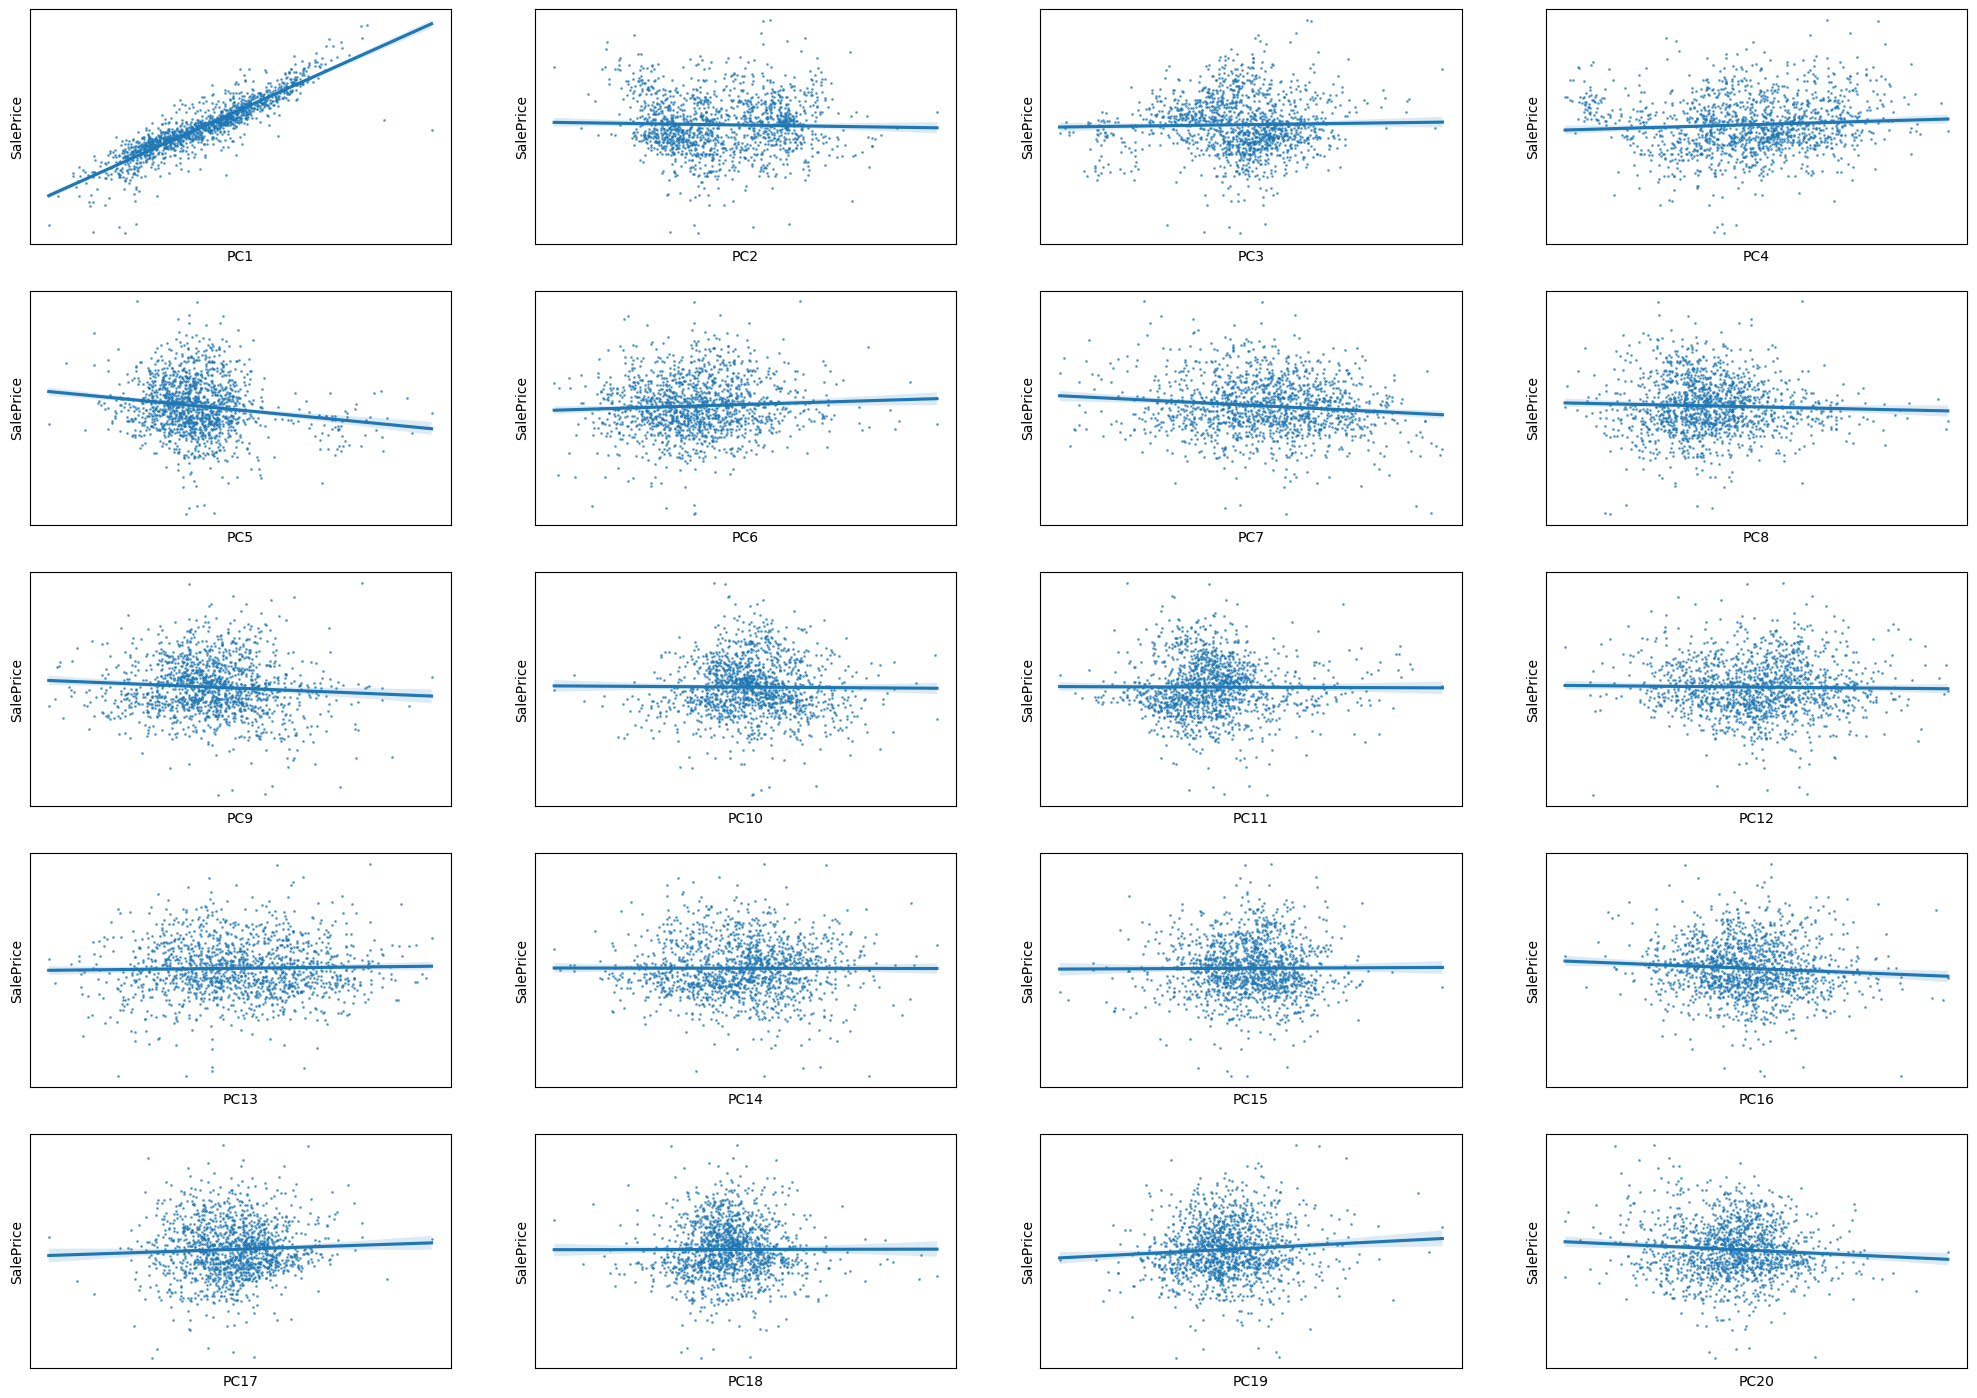

In [38]:
plt.figure(figsize=(25,18),dpi=100)
for i in range(1,21):
    plt.subplot(5,4,i)
    sns.regplot(x=df_num.iloc[:1460,(i-1)],y=train_y,scatter_kws={'s':1,'alpha':0.6}) 
    plt.yticks(ticks=[])
    plt.xticks(ticks=[])

In [39]:
df_num['y']=train_y
df_num.loc[(df_num.PC1>7.5)&(df_num.y<12.5),'PC1']=np.nan
df_num=df_num.drop('y',axis=1)

In [40]:
imp=SimpleImputer(strategy='median')
df_num=pd.DataFrame(imp.fit_transform(df_num),columns=df_num.columns)

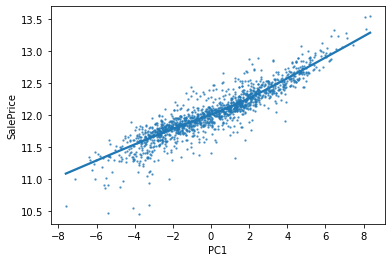

In [41]:
sns.regplot(x=df_num.iloc[:1460,0],y=train_y,scatter_kws={'s':2,'alpha':0.6},lowess=True)

In [42]:
df_num

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,1.896633,0.894154,-1.795209,1.358566,0.293749,-1.778353,0.283051,0.003003,0.582551,-0.598494,...,-0.215495,-0.312638,0.301011,0.105017,-0.026866,0.118763,0.012504,-0.670718,0.028363,-0.100961
1,-0.029662,-1.555359,1.178973,0.452057,-1.746693,2.417726,-0.486185,2.674023,0.084213,-0.446900,...,-0.195436,0.676102,-0.326422,-0.701174,-0.365125,-1.164337,-0.345142,-0.078570,0.085101,0.525388
2,2.175832,0.691865,-1.302699,0.911115,-0.082286,-0.356651,0.808168,-0.915762,0.070061,-0.160477,...,-0.802974,0.012036,0.539820,0.496964,0.537789,-0.553782,0.458766,-0.433433,-0.324942,-0.045618
3,-0.059634,0.956054,0.793441,0.534155,-0.002936,-0.398615,-1.085772,-2.224891,0.692936,2.788246,...,0.035212,0.536684,-0.572530,-0.158504,1.527102,0.757924,-0.482718,-0.529609,-0.276695,-0.524384
4,4.809102,1.182461,-0.075221,1.388205,-0.219995,0.392379,1.167742,-0.800229,-0.500190,0.313609,...,0.464956,-0.357720,-0.286306,0.266778,0.776802,0.085692,-0.080557,-0.301234,-0.210948,-0.249258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-4.982064,2.774754,-3.176039,0.352755,-0.070800,1.211949,-0.355618,-0.584337,-0.063251,-1.437479,...,-0.185962,0.924344,0.353410,-0.246118,0.057310,-0.403060,0.295799,0.708913,-0.190104,0.404372
2915,-3.753494,2.455546,-3.311656,0.829601,0.580433,0.496092,0.317261,-0.795477,1.149454,-0.638189,...,0.492807,0.931417,-0.713765,-0.864935,0.018156,0.184032,0.318301,0.692940,0.409661,-0.109512
2916,0.612600,-2.285808,3.184949,1.933398,-0.972580,0.152431,1.951907,-0.029160,-2.443472,-0.393412,...,-0.048580,-0.037471,-0.126482,-0.085287,0.787749,0.356252,-0.605965,1.320679,1.059547,0.247685
2917,-2.684191,-0.145269,-0.306095,-0.561931,-0.532371,2.681426,0.944534,1.750282,1.085550,-2.523706,...,0.135718,0.447064,1.234784,0.715867,0.625382,0.824094,-0.164413,0.369408,-0.329017,-0.295812


In [43]:
df_obj=df_obj.drop('Id',axis=1)
pd.DataFrame(df_obj.isnull().sum()).sort_values(0,ascending=False)[:10]

,0
MasVnrType,24
MSZoning,4
SaleType,1
Electrical,1
KitchenQual,1
Exterior2nd,1
Exterior1st,1
FireplaceQu,0
HeatingQC,0
CentralAir,0


In [44]:
median_col=pd.DataFrame(df_obj.isnull().sum()).sort_values(0,ascending=False).index[1:7]
median_col

Index(['MSZoning', 'SaleType', 'Electrical', 'KitchenQual', 'Exterior2nd',
       'Exterior1st'],
      dtype='object')

In [45]:
for col in list(median_col):
    df_obj[col]=df_obj[col].fillna(df_obj[col].value_counts().index[0])

In [46]:
df_obj_MasVnrType=df_obj['MasVnrType']
df_obj_without=df_obj.drop('MasVnrType',axis=1)

In [47]:
df_obj_nona=df_obj.dropna(axis=0)
df_obj_MasVnrType_na=df_obj_nona['MasVnrType']
df_obj_without_na=df_obj_nona.drop('MasVnrType',axis=1)

In [48]:
onehot=OneHotEncoder()
df_obj_without_na=onehot.fit_transform(df_obj_without_na)

In [49]:
# for n in [2,4,8,16,32]:
#     knn_or=OneVsRestClassifier(KNeighborsClassifier(weights='distance',n_neighbors=n))
#     knn_or.fit(X=df_obj_without_na,y=df_obj_MasVnrType_na)
#     print(n,accuracy_score(df_obj_MasVnrType_na,knn_or.predict(df_obj_without_na)))

In [50]:
knn_or=OneVsRestClassifier(KNeighborsClassifier(weights='distance',n_neighbors=8))
knn_or.fit(X=df_obj_without_na,y=df_obj_MasVnrType_na)
Mas_pred=knn_or.predict(onehot.fit_transform(df_obj_without))

In [51]:
df_obj.loc[df_obj.MasVnrType.isnull()==True,'MasVnrType']=Mas_pred[df_obj.MasVnrType.isnull()]

In [52]:
df_obj['y']=train_y

In [53]:
one_hot_=[]
for col in list(df_obj.columns)[:-1]:
    tmp=df_obj[[col,'y']]
    tmp=tmp.groupby(col).mean().reset_index()
    if (max(tmp.y)-min(tmp.y))<=(2*np.std(train_y)):
        one_hot_.append(col)
len(one_hot_)

34

In [54]:
df_obj_one=df_obj[one_hot_]
df_obj_ordinal=df_obj.drop(one_hot_,axis=1)

In [55]:
df_obj_one=onehot.fit_transform(df_obj_one)

In [56]:
for col in list(df_obj_ordinal.columns)[:-1]:
    tmp=df_obj_ordinal[[col,'y']].groupby(col).mean().reset_index()
    tmp['y']=tmp['y']/sum(tmp['y'])
    change={}
    for i,j in zip(tmp[col],tmp['y']):
        change[i]=j
    df_obj_ordinal[col]=df_obj_ordinal[col].replace(change)

In [57]:
df_obj_ordinal=df_obj_ordinal.drop('y',axis=1)

In [58]:
df_obj=np.concatenate((df_obj_ordinal,df_obj_one.toarray()),axis=1)

In [59]:
df_num=df_num.values

In [60]:
df_all=np.concatenate((df_num,df_obj),axis=1)

In [61]:
df_train=df_all[:1460,:]
df_test=df_all[1460:,:]

In [62]:
pls=PLSRegression()
best_clf = GridSearchCV(pls,scoring='neg_root_mean_squared_error',cv=10,n_jobs=1,
                        param_grid={'n_components':[2,4,8,16]})
best_clf.fit(df_train,train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='deprecated', n_jobs=1,
             param_grid={'n_components': [2, 4, 8, 16]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [63]:
best_clf.best_score_

-0.12416222517359728

In [64]:
best_clf.best_params_

{'n_components': 16}

In [65]:
rid=Ridge()
best_clf = GridSearchCV(rid,scoring='neg_root_mean_squared_error',cv=10,n_jobs=1,
                        param_grid={'alpha': [0.01,0.1,1,10]})
best_clf.fit(df_train,train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=1,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [66]:
best_clf.best_score_

-0.1162268954381959

In [67]:
best_clf.best_params_

{'alpha': 10}

In [68]:
svr=SVR(kernel='poly',degree=2)
best_m=GridSearchCV(svr,param_grid={'C':[0.0001,0.001],'epsilon':[0.1,0.2,0.3],'gamma':[1,2]},
                   cv=10,n_jobs=3,scoring='neg_root_mean_squared_error')
best_m.fit(df_train,train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': [0.0001, 0.001], 'epsilon': [0.1, 0.2, 0.3],
                         'gamma': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [69]:
best_m.best_params_

{'C': 0.0001, 'epsilon': 0.1, 'gamma': 1}

In [70]:
best_m.best_score_

-0.11844621838581545

In [71]:
reg=StackingRegressor(estimators=[('svm',SVR(kernel='poly',degree=2,C=0.0001,epsilon=0.1,gamma=1)),
                                 ('ridge',Ridge(alpha=10))],
                     final_estimator=PLSRegression(n_components=2))
cv=cross_validate(reg,X=df_train,y=train_y,cv=10,scoring='neg_root_mean_squared_error',n_jobs=1)

In [72]:
np.mean(cv['test_score'])

-0.11363065091032336

In [73]:
reg=StackingRegressor(estimators=[('svm',SVR(kernel='poly',degree=2,C=0.0001,epsilon=0.1,gamma=1)),
                                 ('ridge',Ridge(alpha=10))],
                     final_estimator=PLSRegression(n_components=2))
reg.fit(df_train,train_y)
y_pred=reg.predict(df_test)

In [74]:
y_pred=np.expm1(y_pred)
y_pred=pd.DataFrame(y_pred)
y_pred=y_pred.reset_index()
y_pred.columns=['Id','SalePrice']
y_pred['Id']=range(1461,2920)

In [75]:
y_pred

,Id,SalePrice
0,1461,117489.223294
1,1462,159995.137371
2,1463,181616.392895
3,1464,197085.435226
4,1465,186133.127854
...,...,...
1454,2915,86155.837466
1455,2916,83018.588209
1456,2917,173461.178874
1457,2918,115671.268436


In [76]:
y_pred.to_csv('./y_pred.csv',index=False)